In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import os

FREQUENCIES_COUNT = 50000
# https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array
EACH_N_ELEMENT = 10

# https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
def read_wav(wav_file_name):
    sr, signal = wavfile.read(wav_file_name)
    return (sr, signal[:FREQUENCIES_COUNT:EACH_N_ELEMENT, 0]) # use the first channel (or take their average, alternatively)

def fetch_frequencies(wav_file_name):
    sr, y = read_wav(wav_file_name)
    return y

def show_frequency_spectrum(wav_file_name):
    sr, y = read_wav(wav_file_name)
    t = np.arange(len(y)) / float(sr)
    
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, y)
    plt.xlabel('t')
    plt.ylabel('y')

    plt.show()


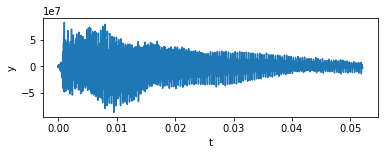

In [2]:
show_frequency_spectrum('samples/C/train/1/splitted_chord007.wav')

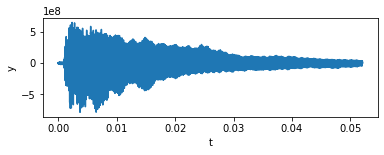

In [3]:
show_frequency_spectrum('samples/A/train/1/splitted_chord007.wav')

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [5]:
model = keras.Sequential([
    keras.layers.Dense(FREQUENCIES_COUNT),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
import glob

a_train_files = glob.glob("samples/A/train/*/*.wav")
c_train_files = glob.glob("samples/C/train/*/*.wav")

train_files  = a_train_files + c_train_files
train_files_data = tf.convert_to_tensor([tf.convert_to_tensor(fetch_frequencies(file), np.int32) for file in train_files])
labels = {'A': 1, 'C': 0}
train_labels = tf.convert_to_tensor([labels['A']] * len(a_train_files) + [labels['C']] * len(c_train_files), np.int32)

In [7]:
model.fit(train_files_data, train_labels, epochs=7)

Train on 51 samples
Epoch 1/7
51/51 [==============================] - 4s 87ms/sample - loss: 2464907906.5098 - accuracy: 0.3922
Epoch 2/7
51/51 [==============================] - 3s 59ms/sample - loss: 4298139269.0196 - accuracy: 0.5490
Epoch 3/7
51/51 [==============================] - 3s 60ms/sample - loss: 83017301.6471 - accuracy: 0.9216
Epoch 4/7
51/51 [==============================] - 3s 57ms/sample - loss: 338137498.3529 - accuracy: 0.9412
Epoch 5/7
51/51 [==============================] - 3s 55ms/sample - loss: 72408576.0000 - accuracy: 0.9804
Epoch 6/7
51/51 [==============================] - 3s 56ms/sample - loss: 169136569.7255 - accuracy: 0.9412
Epoch 7/7
51/51 [==============================] - 3s 54ms/sample - loss: 0.0000e+00 - accuracy: 1.0000


In [9]:
a_test_files = glob.glob("samples/A/test/*.wav")
c_test_files = glob.glob("samples/C/test/*.wav")

test_files  = a_test_files + c_test_files
train_files_data = tf.convert_to_tensor([tf.convert_to_tensor(fetch_frequencies(file), np.int32) for file in test_files])

model.predict(train_files_data)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)